# NIR SPECTRA Project

Predicting a quantity of interest from spectral data

Near infra-red spectroscopy is a technique used in a number of industries, including food and agrochemical quality control. The goal is to determine a quantity of interest, for instance, protein content of milk, from spectrometer measurements.

More information: 
[](https://en.wikipedia.org/wiki/Near-infrared_spectroscopy)

The data for this assignment consists of the following columns (in this particular order):

- Sample number.
- The quantity to predict.
- The rest of the columns are the spectral data.

**Your task:**

- Perform an exploratory analysis of the data.
- Develop a predictive model for the second column and report its accuracy in terms of R-squared and RMSE error.
- Explain your model.


In [145]:
# loading libraries
import pandas as pd
import numpy as np
import sklearn
from sklearn.utils import shuffle
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# settings
sns.set(style="white", palette="muted", color_codes=True)

# Loading data

In [5]:
df = pd.read_csv('./cal 2018.csv', sep=";", header=None, index_col=[0])

In [6]:
df.head()

,1,2,3,4,5,6,7,8,9,10,...,672,673,674,675,676,677,678,679,680,681
0,,,,,,,,,,,,,,,,,,,,,
1,12.740000,0.597482,0.595978,0.593623,0.590840,0.587451,0.583092,0.578666,0.572134,0.566125,...,0.119548,0.118791,0.118170,0.117522,0.116919,0.116422,0.115861,0.115367,0.114876,0.114548
2,35.721199,0.954192,0.953237,0.952002,0.950426,0.948382,0.946138,0.943543,0.940570,0.937514,...,0.287561,0.285157,0.282881,0.280734,0.278929,0.277288,0.275735,0.274133,0.272768,0.271574
3,12.000000,0.611137,0.609566,0.607430,0.604767,0.601434,0.597316,0.592598,0.586992,0.580741,...,0.116174,0.115513,0.114890,0.114354,0.113720,0.113223,0.112702,0.112212,0.111764,0.111432
4,13.844976,0.342604,0.343687,0.344696,0.345664,0.346574,0.347402,0.348187,0.348870,0.349470,...,0.084568,0.084324,0.084156,0.084029,0.083939,0.083858,0.083770,0.083700,0.083641,0.083626
5,19.299999,0.760703,0.760871,0.761004,0.761058,0.761009,0.760830,0.760615,0.760404,0.760069,...,0.309897,0.307698,0.305618,0.303555,0.301619,0.299720,0.297918,0.296330,0.294762,0.293355


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3908 entries, 1 to 3908
Columns: 681 entries, 1 to 681
dtypes: float64(681)
memory usage: 20.3 MB


In [148]:
X = df.iloc[:, 1:]

In [149]:
y = df.iloc[:, 0]

In [150]:
y.describe()

count    3908.000000
mean       31.247135
std        20.044317
min         3.060644
25%        13.096103
50%        22.770000
75%        51.250000
max        76.603981
Name: 1, dtype: float64

### Distribution plot for the predicted quantity

A plot to describe the distribution of measured predicted values

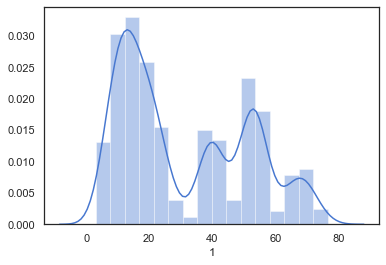

In [151]:
# Set up the matplotlib figure
sns.despine()

sns.distplot(y, hist=True, kde=True, norm_hist=True)

plt.show()

In [152]:
# get min and max values for whole NIR spectra

print("Min :", round(X.values.min(), 2))
print("Max :", round(X.values.max(), 2))

Min : 0.03
Max : 1.18


## A few examples of spectra visualised

In [227]:
n_samples=6
X_sample, y_sample = shuffle(X, y, n_samples=n_samples)

In [228]:
sample_stack = X_sample.stack()

In [229]:
sample_stack.index.names = ['sample_id', 'nir_column']
sample_stack.name = 'nir_value'

In [230]:
sample_df = sample_stack.reset_index()

In [231]:
sample_df['sample_id'] = sample_df['sample_id'].astype('str')

In [232]:
sample_target.sort_values()

0
2792     8.650000
3276    51.168152
3876    51.735722
1614    52.462292
390     66.618828
Name: 1, dtype: float64

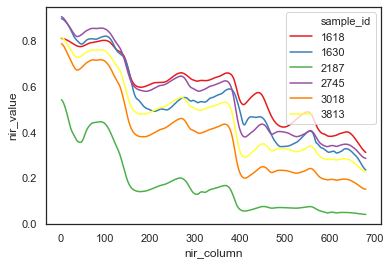

In [233]:
sns.lineplot(x='nir_column', y='nir_value',
             hue='sample_id', data=sample_df, palette=sns.color_palette("Set1", n_samples))
plt.show()

## Correlation between predictors

In [234]:
corr_matrix = X.sample(500).corr()

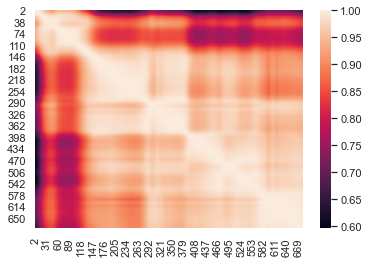

In [235]:
sns.heatmap(corr_matrix)

There is a high level of multicollinearity between the predictors.

### Top 25 predictors for response
Best pearson coefficients for the correlation of first column 

In [236]:
coefficients = X.corrwith(y).sort_values(ascending=False)[:25]

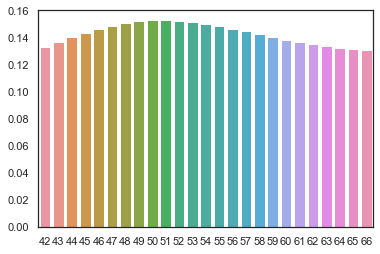

In [237]:
sns.barplot(x=coefficients.index.astype(str), y=coefficients.values)

In [238]:
best_predictor_index = coefficients.idxmax()
best_predictor_value = coefficients.max()

In [239]:
print(f"Best predictor column index: {best_predictor_index}\nValue: {round(best_predictor_value, 2)}")

Best predictor column index: 51
Value: 0.15


## Scatter plot for best predictor

Scatterplot shows the relationship between the best predictor and the response - no correlation

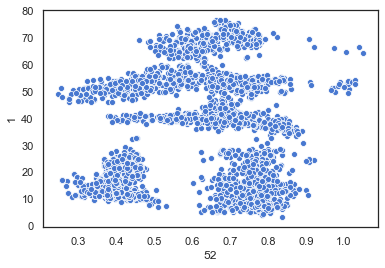

In [251]:
sns.scatterplot(x=X.iloc[:, best_predictor_index-1], y=y)

# The model

In [335]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.preprocessing import scale 

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression

from sklearn import model_selection

In [336]:
# K-Fold cross validator
kf_10 = model_selection.KFold( n_splits=10, shuffle=True, random_state=1)

## Principal component regression 

First option is to reduce the dimentionality and try to figure out the **optimal number of components**.
The first objective is to find an acceptable number of principal components giving us a **low RMSE and high enough R2**

In [337]:
# instance of PCA model
pca = PCA()

In [338]:
# fit and transform the scaled original predictor matrix
X_reduced = pca.fit_transform(scale(X))
n = len(X_reduced)

# Basic linear regression model
regr = LinearRegression()
rmse_scores = []
r2_scores = []

# Calculate RMSE and R2 with only the intercept (no principal components in regression)
rmse = -1*model_selection.cross_val_score(regr, np.ones((n,1)), y.ravel(), cv=kf_10, scoring='neg_root_mean_squared_error').mean()    
r2 = -1*model_selection.cross_val_score(regr, np.ones((n,1)), y.ravel(), cv=kf_10, scoring='r2').mean()    
rmse_scores.append(rmse)
r2_scores.append(r2)

# Calculating RMSE and R2 for up to 70 components
for i in np.arange(1, 70):
    rmse = -1*model_selection.cross_val_score(regr, X_reduced[:,:i], y.ravel(), cv=kf_10, scoring='neg_root_mean_squared_error').mean()
    r2 = model_selection.cross_val_score(regr, X_reduced[:,:i], y.ravel(), cv=kf_10, scoring='r2').mean()
    
    rmse_scores.append(rmse)
    r2_scores.append(r2)

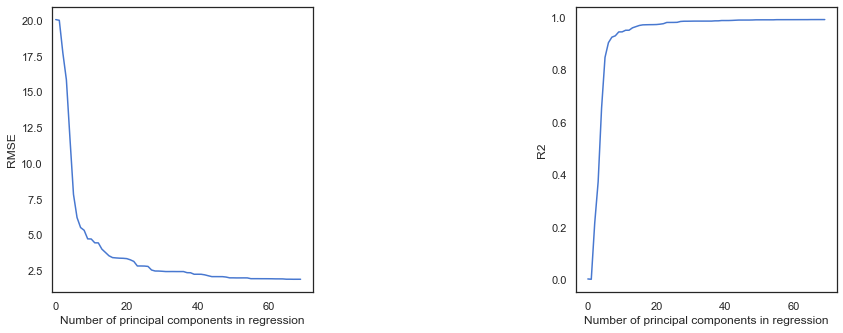

In [339]:
fig, (ax1, ax2) = plt.subplots(1, 2)
# Plot results    
ax1.plot(rmse_scores)

ax1.set_xlabel('Number of principal components in regression')
ax1.set_ylabel('RMSE')
ax1.set_xlim(xmin=-1);

ax2.plot(r2_scores)
ax2.set_xlabel('Number of principal components in regression')
ax2.set_ylabel('R2')

fig.tight_layout()
fig.set_size_inches(15, 5)
plt.show()

The graph for RMSE and R2 in relation to number of principal components shows that using around **50 principal components would suffice**.

In [369]:
# We split the initial data to train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=22)

In [370]:
# A new PCA object only for training data
pca2 = PCA()

In [371]:
# fit pca2 and transform scaled training data
n_components = 50
X_train_red = pca2.fit_transform(scale(X_train))[:,:n_components]

# transform test data
X_test_red = pca2.transform(scale(X_test))[:, :n_components]

In [372]:
# Train regression model on training data 
regr = LinearRegression()
regr.fit(X_train_red, y_train)

# Prediction with test data
pred = regr.predict(X_test_red)

# Score the model
rmse = -1*model_selection.cross_val_score(regr, X_test_red[:,:n_components], y_test.ravel(), cv=kf_10, scoring='neg_root_mean_squared_error').mean()
r2 = model_selection.cross_val_score(regr, X_test_red[:,:n_components], y_test.ravel(), cv=kf_10, scoring='r2').mean()

print(f"Final RMSE: {round(rmse, 2)}")
print(f"Final R2: {round(r2, 2)}")

Final RMSE: 2.04
Final R2: 0.99


## Discussion

The final cross-validated **R2** for the test data shows that we explain roughly **99% of variation** in the predicted value by using **50 principal components** in the regression.

The cross-validated **root mean square error (RMSE) accounted to 2.04 in the predicted units**

In [377]:
y.mean()

31.247134609877175

In [379]:
y.std()

20.04431706106237

In [ ]:
2.04